In [14]:
import configparser
from pathlib import Path

config = configparser.ConfigParser()
config.read('../../../data/config/config.cfg')

phenopackets_out_dir = ('..' / Path(config.get('Paths', 'phenopackets_out'))).resolve()

phenopackets_out_dir

WindowsPath('C:/Users/Surface/OneDrive/Documents/DataSpell/ERKER2Phenopackets/ERKER2Phenopackets/data/out/phenopackets')

# read in data from phenopackets

In [15]:
from ERKER2Phenopackets.src.utils.io import read_files

example_phenopackets_dir = phenopackets_out_dir / 'example-phenopackets-from-synthetic-data'
is_synth_data = True
pps = read_files(example_phenopackets_dir)

# convert phenopackets to dataframe
Necessary fields:
- id
- zygosity
- cHGVS mutation
- Obsesity Class and timestamp

In [16]:
from typing import Tuple, Any
from phenopackets import Phenopacket

sex_map = {0: 'unknown', 1: 'female', 2: 'male', 3: 'other'}

def extract_phenotype(phenotypic_features, i) -> Tuple[str, str, bool, int]:
    phenotypic_features = phenotypic_features[i]
    obesity_class_hpo = phenotypic_features.type.id
    obesity_class = phenotypic_features.type.label
    excluded = phenotypic_features.excluded
    onset = phenotypic_features.onset.timestamp.ToSeconds()
    return obesity_class_hpo, obesity_class, excluded, onset

def extract_fields(phenopacket: Phenopacket):
    pp_id = int(phenopacket.id)
    dob = phenopacket.subject.date_of_birth.ToSeconds()
    sex = sex_map[phenopacket.subject.sex]

    try:
        variation_descriptor = phenopacket.interpretations[0].diagnosis.genomic_interpretations[0].variant_interpretation.variation_descriptor
        c_hgvs = variation_descriptor.expressions[1].value
        zygosity = variation_descriptor.allelic_state.label
    except IndexError:
        return None

    phenotypic_features = phenopacket.phenotypic_features

    phenotype_data = []
    for i in range(5):
        try:
            obesity_class_hpo, obesity_class, excluded, onset = extract_phenotype(phenotypic_features, i)
        except IndexError:
            obesity_class_hpo, obesity_class, excluded, onset = None, None, None, None
        phenotype_data.extend([obesity_class_hpo, obesity_class, excluded, onset])

    return tuple([pp_id, dob, sex, zygosity, c_hgvs] + phenotype_data)


In [17]:
# todo: some people have multiple variants max 3

In [18]:
phenopacket = pps[0]
variation_descriptor = phenopacket.interpretations[0].diagnosis.genomic_interpretations[0].variant_interpretation

phenopacket

id: "0"
subject {
  id: "0"
  date_of_birth {
    seconds: 946684800
  }
  sex: FEMALE
  taxonomy {
    id: "NCBITaxon:9606"
    label: "Homo sapiens"
  }
}
phenotypic_features {
  type {
    id: "HP:0001513"
    label: "Obesity"
  }
  excluded: true
  onset {
    timestamp {
      seconds: 708652800
    }
  }
}
interpretations {
  id: "e0dd47b3-6e13-4507-84a7-5606bee17024"
  progress_status: SOLVED
  diagnosis {
    disease {
      id: "ORPHA:71529"
      label: "Obesity due to melanocortin 4 receptor deficiency"
    }
    genomic_interpretations {
      subject_or_biosample_id: "0"
      interpretation_status: CONTRIBUTORY
      variant_interpretation {
        variation_descriptor {
          id: "id:A"
          expressions {
            syntax: "hgvs"
            value: "NP_005903.2:p.(Val103Ile)"
          }
          expressions {
            syntax: "hgvs"
            value: "NM_005912.3:c.181G>T"
          }
          allelic_state {
            id: "GENO:0000135"
            

In [19]:
for pp in pps:
    print(extract_fields(pp))

(0, 946684800, 'female', 'heterozygous', 'NM_005912.3:c.181G>T', 'HP:0001513', 'Obesity', True, 708652800, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
(1, 915148800, 'female', 'heterozygous', 'NM_005912.3:c.307G>A', 'HP:0001513', 'Obesity', True, 1254268800, 'HP:0001513', 'Obesity', False, 967507200, None, None, None, None, None, None, None, None, None, None, None, None)
None
None
(12, 757382400, 'male', 'heterozygous', 'NM_005912.3:c.307G>A', 'HP:0001513', 'Obesity', False, 1118793600, 'HP:0025500', 'Class II obesity', False, 1267056000, None, None, None, None, None, None, None, None, None, None, None, None)
(13, 757382400, 'male', 'heterozygous', 'NM_005912.3:c.307G>A', 'HP:0001513', 'Obesity', True, 1234051200, 'HP:0001507', 'Growth abnormality', True, 985219200, 'HP:0001507', 'Growth abnormality', False, 876528000, None, None, None, None, None, None, None, None)
None
None
None
(17, 1072915200, 'female', 'homozygous', 'NM_005912.3:

In [20]:
import polars as pl

data = list(filter(lambda x: x is not None, map(extract_fields, pps)))

data, len(data)

([(0,
   946684800,
   'female',
   'heterozygous',
   'NM_005912.3:c.181G>T',
   'HP:0001513',
   'Obesity',
   True,
   708652800,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None),
  (1,
   915148800,
   'female',
   'heterozygous',
   'NM_005912.3:c.307G>A',
   'HP:0001513',
   'Obesity',
   True,
   1254268800,
   'HP:0001513',
   'Obesity',
   False,
   967507200,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None),
  (12,
   757382400,
   'male',
   'heterozygous',
   'NM_005912.3:c.307G>A',
   'HP:0001513',
   'Obesity',
   False,
   1118793600,
   'HP:0025500',
   'Class II obesity',
   False,
   1267056000,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None),
  (13,
   757382400,
   'male',
   'heterozygous',
   'NM_005912.3:c.307G>A',
   'HP:0001513',
   'Obesity',
   True

In [21]:
columns = ['id', 'date_of_birth', 'sex', 'zygosity', 'c_hgvs', 'obesity_class_hpo0', 'obesity_class0', 'phenotype_refuted0', 'onset0', 'obesity_class_hpo1', 'obesity_class1', 'phenotype_refuted1', 'onset1', 'obesity_class_hpo2', 'obesity_class2', 'phenotype_refuted2', 'onset2', 'obesity_class_hpo3', 'obesity_class3', 'phenotype_refuted3', 'onset3', 'obesity_class_hpo4', 'obesity_class4', 'phenotype_refuted4', 'onset4']
transposed_data = list(zip(*data))

df = pl.DataFrame({col: transposed_data[i] for i, col in enumerate(columns)})

In [22]:
df.head(50)

id,date_of_birth,sex,zygosity,c_hgvs,obesity_class_hpo0,obesity_class0,phenotype_refuted0,onset0,obesity_class_hpo1,obesity_class1,phenotype_refuted1,onset1,obesity_class_hpo2,obesity_class2,phenotype_refuted2,onset2,obesity_class_hpo3,obesity_class3,phenotype_refuted3,onset3,obesity_class_hpo4,obesity_class4,phenotype_refuted4,onset4
i64,i64,str,str,str,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64
0,946684800,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,708652800,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1,915148800,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1254268800,"""HP:0001513""","""Obesity""",false,967507200,null,null,null,null,null,null,null,null,null,null,null,null
12,757382400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",false,1118793600,"""HP:0025500""","""Class II obesi…",false,1267056000,null,null,null,null,null,null,null,null,null,null,null,null
13,757382400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1234051200,"""HP:0001507""","""Growth abnorma…",true,985219200,"""HP:0001507""","""Growth abnorma…",false,876528000,null,null,null,null,null,null,null,null
17,1072915200,"""female""","""homozygous""","""NM_005912.3:c.…","""HP:0025500""","""Class II obesi…",true,638409600,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
18,1136073600,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,916272000,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,1009843200,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1087257600,"""HP:0001513""","""Obesity""",true,825811200,"""HP:0001507""","""Growth abnorma…",false,976406400,null,null,null,null,null,null,null,null
20,1072915200,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,872208000,"""HP:0025499""","""Class I obesit…",false,674524800,"""HP:0001507""","""Growth abnorma…",false,1037750400,null,null,null,null,null,null,null,null
21,1136073600,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,938563200,"""HP:0001513""","""Obesity""",true,1149724800,"""HP:0001507""","""Growth abnorma…",false,1451606400,null,null,null,null,null,null,null,null


# Data Cleaning

There is only one person with an unspecified zygosity, so we can drop this person.

In [23]:
df = df.filter(df['zygosity'] != 'unspecified zygosity')

In [24]:
# add new timestamps to make the data more realistic
if is_synth_data:
    from ERKER2Phenopackets.src.utils.dateutils import date_to_seconds, seconds_to_date, generate_random_date
    def random_onsets():
        seconds_per_day = 60 * 60 * 24
        dob = generate_random_date('1990-01-01', '2010-01-01')
        dob_seconds = date_to_seconds(dob)
        # dates:
        # 1. untersuchung bei geburt
        # 2. u6: 10 - 12 monate
        # 3. u7: 21 - 24 monate
        # 4. u8: 46 - 48 monate
        # 5. u9: 60 - 64 monate
        intervals = [
            (0, 35),
            (304, 365),
            (639, 730),
            (1399, 1460),
            (1825, 1947)
        ]
    
        onset_dates = [dob_seconds]
        for interval in intervals:
            min_days, max_days = interval
            min_date = seconds_to_date(dob_seconds + min_days * seconds_per_day)
            max_date = seconds_to_date(dob_seconds + max_days * seconds_per_day)
            onset_dates.append(date_to_seconds(generate_random_date(min_date, max_date)))
    
        return onset_dates
    
    dob, u1, u6, u7, u8, u9 = [], [], [], [], [], []
    
    for i in range(df.height):
        cur_dob, cur_u1, cur_u6, cur_u7, cur_u8, cur_u9 = random_onsets()
        dob.append(cur_dob)
        u1.append(cur_u1)
        u6.append(cur_u6)
        u7.append(cur_u7)
        u8.append(cur_u8)
        u9.append(cur_u9)
    
    df = df.with_columns(
        pl.Series(name='date_of_birth', values=dob),
        pl.Series(name='onset0', values=u1),
        pl.Series(name='onset1', values=u6),
        pl.Series(name='onset2', values=u7),
        pl.Series(name='onset3', values=u8),
        pl.Series(name='onset4', values=u9),
    )

In [25]:
df.head(50)

id,date_of_birth,sex,zygosity,c_hgvs,obesity_class_hpo0,obesity_class0,phenotype_refuted0,onset0,obesity_class_hpo1,obesity_class1,phenotype_refuted1,onset1,obesity_class_hpo2,obesity_class2,phenotype_refuted2,onset2,obesity_class_hpo3,obesity_class3,phenotype_refuted3,onset3,obesity_class_hpo4,obesity_class4,phenotype_refuted4,onset4
i64,i64,str,str,str,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64
0,1048896000,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1051228800,null,null,null,1075507200,null,null,null,1106870400,null,null,null,1174003200,null,null,null,1207526400
1,1111795200,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1113782400,"""HP:0001513""","""Obesity""",false,1138233600,null,null,null,1173398400,null,null,null,1236470400,null,null,null,1279584000
12,1185840000,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",false,1186272000,"""HP:0025500""","""Class II obesi…",false,1215820800,null,null,null,1243123200,null,null,null,1307491200,null,null,null,1347494400
13,1073174400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1073347200,"""HP:0001507""","""Growth abnorma…",true,1104624000,"""HP:0001507""","""Growth abnorma…",false,1132358400,null,null,null,1198800000,null,null,null,1238544000
17,852249600,"""female""","""homozygous""","""NM_005912.3:c.…","""HP:0025500""","""Class II obesi…",true,854841600,null,null,null,880329600,null,null,null,913248000,null,null,null,973814400,null,null,null,1013731200
18,1143504000,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1143504000,null,null,null,1174953600,null,null,null,1206489600,null,null,null,1266192000,null,null,null,1303603200
2,1128384000,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1130371200,"""HP:0001513""","""Obesity""",true,1158364800,"""HP:0001507""","""Growth abnorma…",false,1190505600,null,null,null,1253664000,null,null,null,1290297600
20,1037664000,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1038441600,"""HP:0025499""","""Class I obesit…",false,1068163200,"""HP:0001507""","""Growth abnorma…",false,1094601600,null,null,null,1160006400,null,null,null,1201564800
21,656121600,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,657417600,"""HP:0001513""","""Obesity""",true,684201600,"""HP:0001507""","""Growth abnorma…",false,713491200,null,null,null,778377600,null,null,null,818294400


# Preprocessing

Order dataframe by descending number of same c_hgvs mutations

In [26]:
from typing import Callable

def c_hgvs_occurences(df: pl.DataFrame) -> pl.DataFrame:
    return  df.join(other=df.groupby('c_hgvs').agg(pl.count('c_hgvs').alias('count')).select(['c_hgvs','count']), on='c_hgvs', how='inner').select(['count'])
    


def sort_by_method(df: pl.DataFrame, method: Callable[[pl.DataFrame],Any], descending: bool = True) -> pl.DataFrame:
    """Sorts a DataFrame by a given method.
    
    The method must take the dataframe as input and return a new dataframe with only the column to sort by.
    """
    df_new_col = method(df)
    new_col = df_new_col[df_new_col.columns[0]]

    df = df.with_columns(new_col___123=pl.Series(new_col))
    
    sorted_df = df.sort('new_col___123', descending=descending)
    
    return sorted_df.drop('new_col___123')

df = sort_by_method(df, c_hgvs_occurences)

In [27]:
# correct value of refuted columns to match phenotype: only Obesity has refuted true these are our negatives
if is_synth_data:
    df = df.with_columns(
        phenotype_refuted0=df['obesity_class0'] == 'Obesity',
        phenotype_refuted1=df['obesity_class1'] == 'Obesity',
        phenotype_refuted2=df['obesity_class2'] == 'Obesity',
        phenotype_refuted3=df['obesity_class3'] == 'Obesity',
        phenotype_refuted4=df['obesity_class4'] == 'Obesity',
    )

In [28]:
from ERKER2Phenopackets.src.utils.polars_utils import replace_value

# growth abnormality: not recorded phenotype -> replace null
growth_abnormality = 'Growth abnormality'
growth_abnormality_hpo = 'HP:0001507'

for i in range(5):
    df = replace_value(df, f'obesity_class{i}', growth_abnormality, None)
    df = replace_value(df, f'obesity_class_hpo{i}', growth_abnormality_hpo, None)

In [29]:
from ERKER2Phenopackets.src.utils.polars_utils import map_col

# 0: Obesity refuted
# 1: Overweight
# 2: Class I Obesity (HPO)
# 3: Class II Obesity (HPO)
# 4: Class III Obesity (HPO)
def create_label(*args):
    i = list(args[0].keys())[0][-1]
    hpo = args[0]['obesity_class_hpo'+i]
    term = args[0]['obesity_class'+i]
    refuted = args[0]['phenotype_refuted'+i]
    
    if hpo is None or term is None or refuted is None:
        return "Not recorded"

    label = []

    if refuted:
        label.append('Refuted ')
    label.append(term)
    label.append(f' ({hpo})')
    return ''.join(label)

for i in range(5):
    df = map_col(
        df, 
        map_from=[f'obesity_class_hpo{i}', f'obesity_class{i}', f'phenotype_refuted{i}'], 
        map_to=f'obesity_label{i}', 
        mapping=create_label
    )

In [30]:
# normalize timestamps
df = df.with_columns(
    onset0=df['onset0'] - df['date_of_birth'],
    onset1=df['onset1'] - df['date_of_birth'],
    onset2=df['onset2'] - df['date_of_birth'],
    onset3=df['onset3'] - df['date_of_birth'],
    onset4=df['onset4'] - df['date_of_birth'],
)

In [31]:
df.head(50)

id,date_of_birth,sex,zygosity,c_hgvs,obesity_class_hpo0,obesity_class0,phenotype_refuted0,onset0,obesity_class_hpo1,obesity_class1,phenotype_refuted1,onset1,obesity_class_hpo2,obesity_class2,phenotype_refuted2,onset2,obesity_class_hpo3,obesity_class3,phenotype_refuted3,onset3,obesity_class_hpo4,obesity_class4,phenotype_refuted4,onset4,obesity_label0,obesity_label1,obesity_label2,obesity_label3,obesity_label4
i64,i64,str,str,str,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,bool,i64,str,str,str,str,str
1,1111795200,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,1987200,"""HP:0001513""","""Obesity""",true,26438400,null,null,null,61603200,null,null,null,124675200,null,null,null,167788800,"""Refuted Obesit…","""Refuted Obesit…","""Not recorded""","""Not recorded""","""Not recorded"""
12,1185840000,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,432000,"""HP:0025500""","""Class II obesi…",false,29980800,null,null,null,57283200,null,null,null,121651200,null,null,null,161654400,"""Refuted Obesit…","""Class II obesi…","""Not recorded""","""Not recorded""","""Not recorded"""
13,1073174400,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,172800,null,null,false,31449600,null,null,false,59184000,null,null,null,125625600,null,null,null,165369600,"""Refuted Obesit…","""Not recorded""","""Not recorded""","""Not recorded""","""Not recorded"""
20,1037664000,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,777600,"""HP:0025499""","""Class I obesit…",false,30499200,null,null,false,56937600,null,null,null,122342400,null,null,null,163900800,"""Refuted Obesit…","""Class I obesit…","""Not recorded""","""Not recorded""","""Not recorded"""
23,1229212800,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,2678400,"""HP:0001513""","""Obesity""",true,30412800,null,null,false,61171200,null,null,null,120960000,null,null,null,161222400,"""Refuted Obesit…","""Refuted Obesit…","""Not recorded""","""Not recorded""","""Not recorded"""
3,1258243200,"""male""","""heterozygous""","""NM_005912.3:c.…",null,null,null,259200,null,null,null,28252800,null,null,null,61171200,null,null,null,121824000,null,null,null,157680000,"""Not recorded""","""Not recorded""","""Not recorded""","""Not recorded""","""Not recorded"""
32,1137888000,"""male""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,2246400,null,null,false,29116800,null,null,null,57888000,null,null,null,126057600,null,null,null,167875200,"""Refuted Obesit…","""Not recorded""","""Not recorded""","""Not recorded""","""Not recorded"""
37,1026000000,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,3024000,"""HP:0025499""","""Class I obesit…",false,27993600,"""HP:0001513""","""Obesity""",true,55468800,null,null,null,122601600,null,null,null,160617600,"""Refuted Obesit…","""Class I obesit…","""Refuted Obesit…","""Not recorded""","""Not recorded"""
38,908841600,"""female""","""heterozygous""","""NM_005912.3:c.…","""HP:0001513""","""Obesity""",true,2332800,null,null,false,27907200,null,null,null,56419200,null,null,null,124502400,null,null,null,163209600,"""Refuted Obesit…","""Not recorded""","""Not recorded""","""Not recorded""","""Not recorded"""


Overweight, Class I-III Obesity: excluded false
if excluded (refuted) true -> BMI in normal range

only Obesity has refuted true these are our negatives

growth abnormality: not recorded phenotype -> drop rows

# Questions
## Descriptive Statistics
1. How is the split of zygosity? Distribution of sex?
2. Distribution of c_hgvs mutations?
3. What if we split the distribution of c_hgvs mutations by zygosity?
4. Distribution of obesity classes?
5. What if we split the distribution of obesity classes by zygosity?
6. What if we split the distribution of obesity classes by c_hgvs mutation?
7. What if we split the distribution of obesity classes by c_hgvs mutation and zygosity?
8. What if we split by sex?
9. How long does it take for a person to develop the different obesity classes based on their mutation?

## Predictive Statistics
1. What is the probability of a person with a certain c_hgvs mutation to develop a certain obesity class?
2. Prediction model of obesity class based on c_hgvs mutation and zygosity

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from ERKER2Phenopackets.src.utils.polars_utils import barchart, barchart_3d, barchart_subplot, barchart_relative_distribution, barchart_relative_distribution_subplot, piechart_subplot, piechart

figsize = (20, 15)

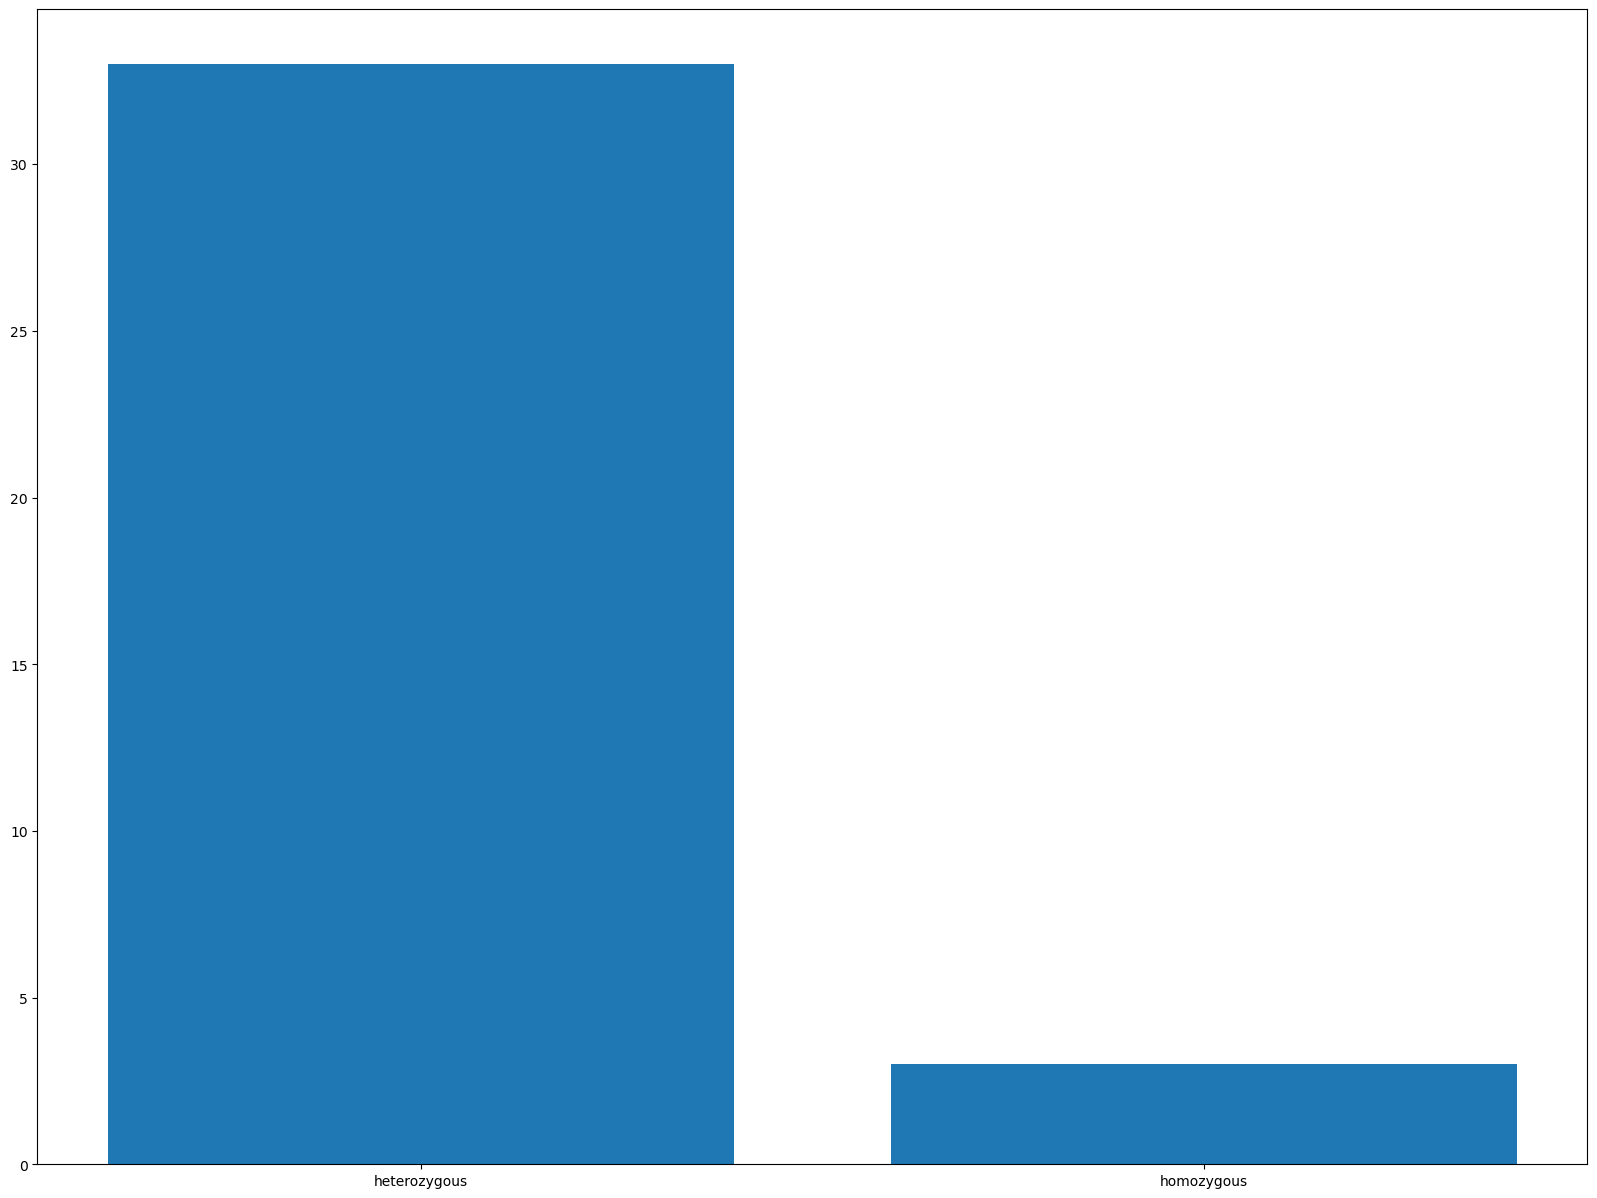

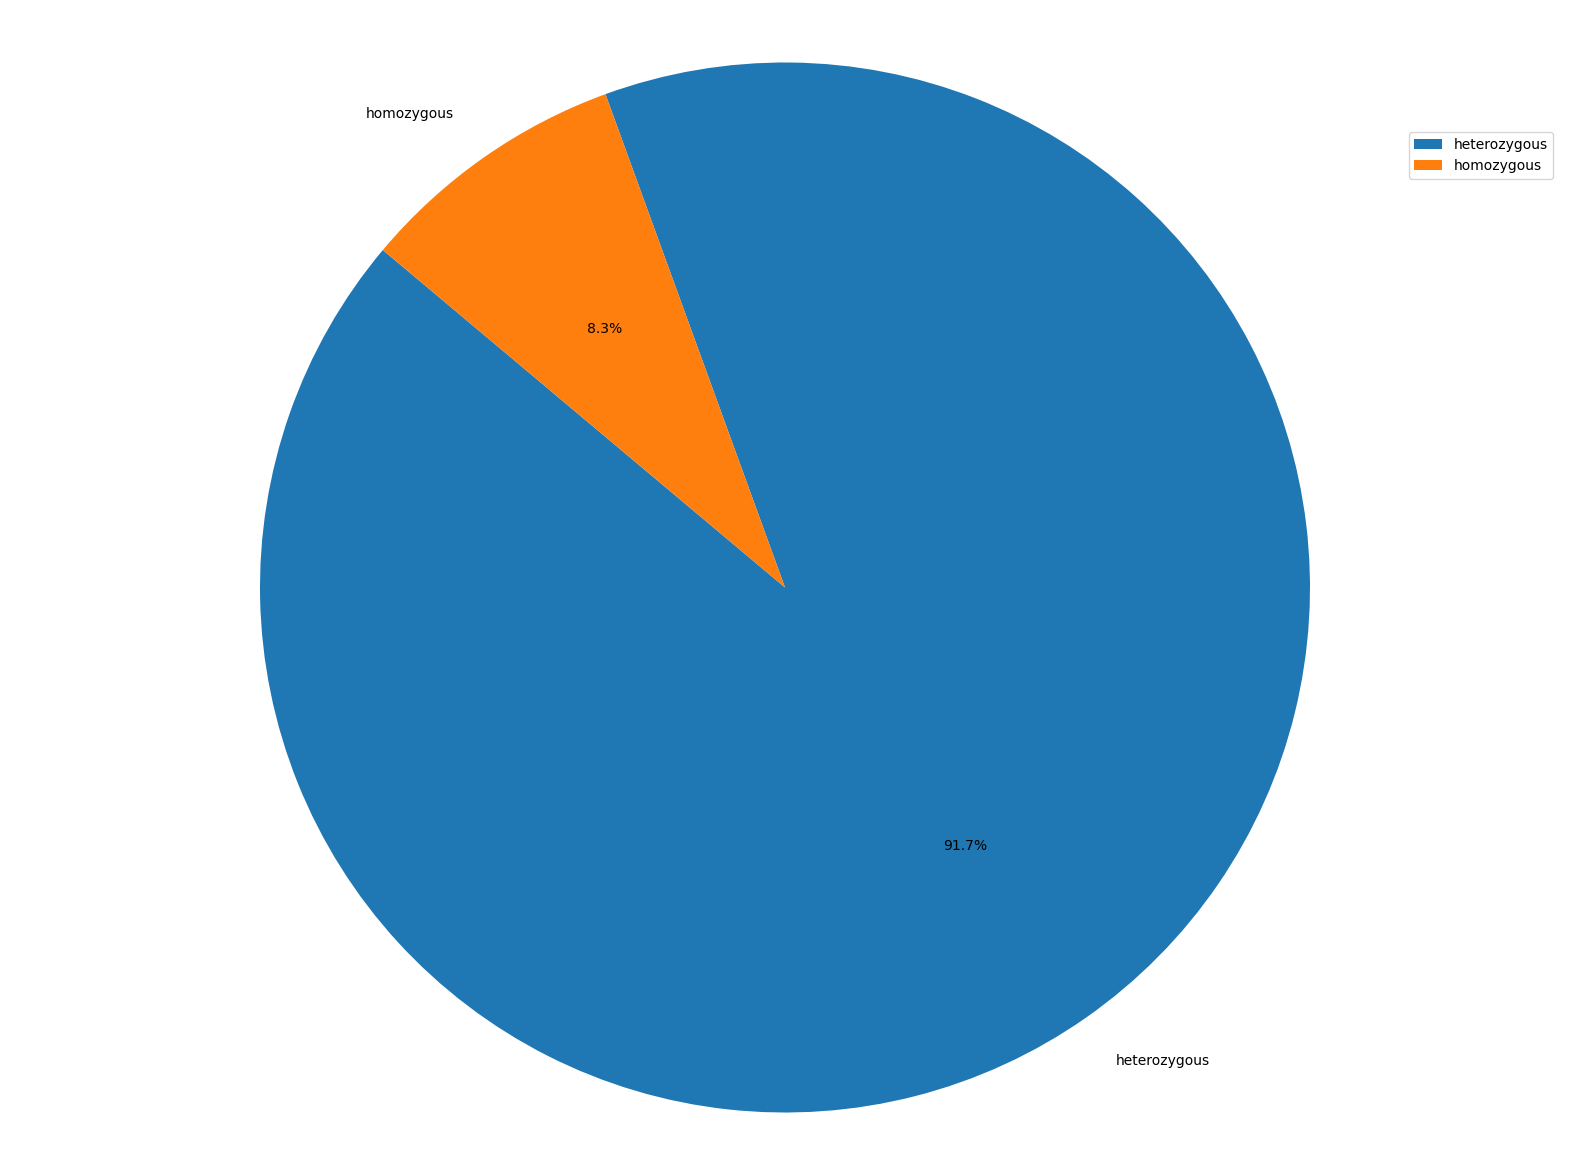

zygosity,count
str,u32
"""heterozygous""",33
"""homozygous""",3


In [33]:
# Descriptive Statistics
# 1. How is the split of zygosity?
grouped_by_zygosity = df.groupby('zygosity').count()
num_zygosity = grouped_by_zygosity.height

barchart(grouped_by_zygosity['zygosity'], grouped_by_zygosity['count'], figsize=figsize)
piechart(grouped_by_zygosity['zygosity'], grouped_by_zygosity['count'], figsize=figsize)

grouped_by_zygosity.head()

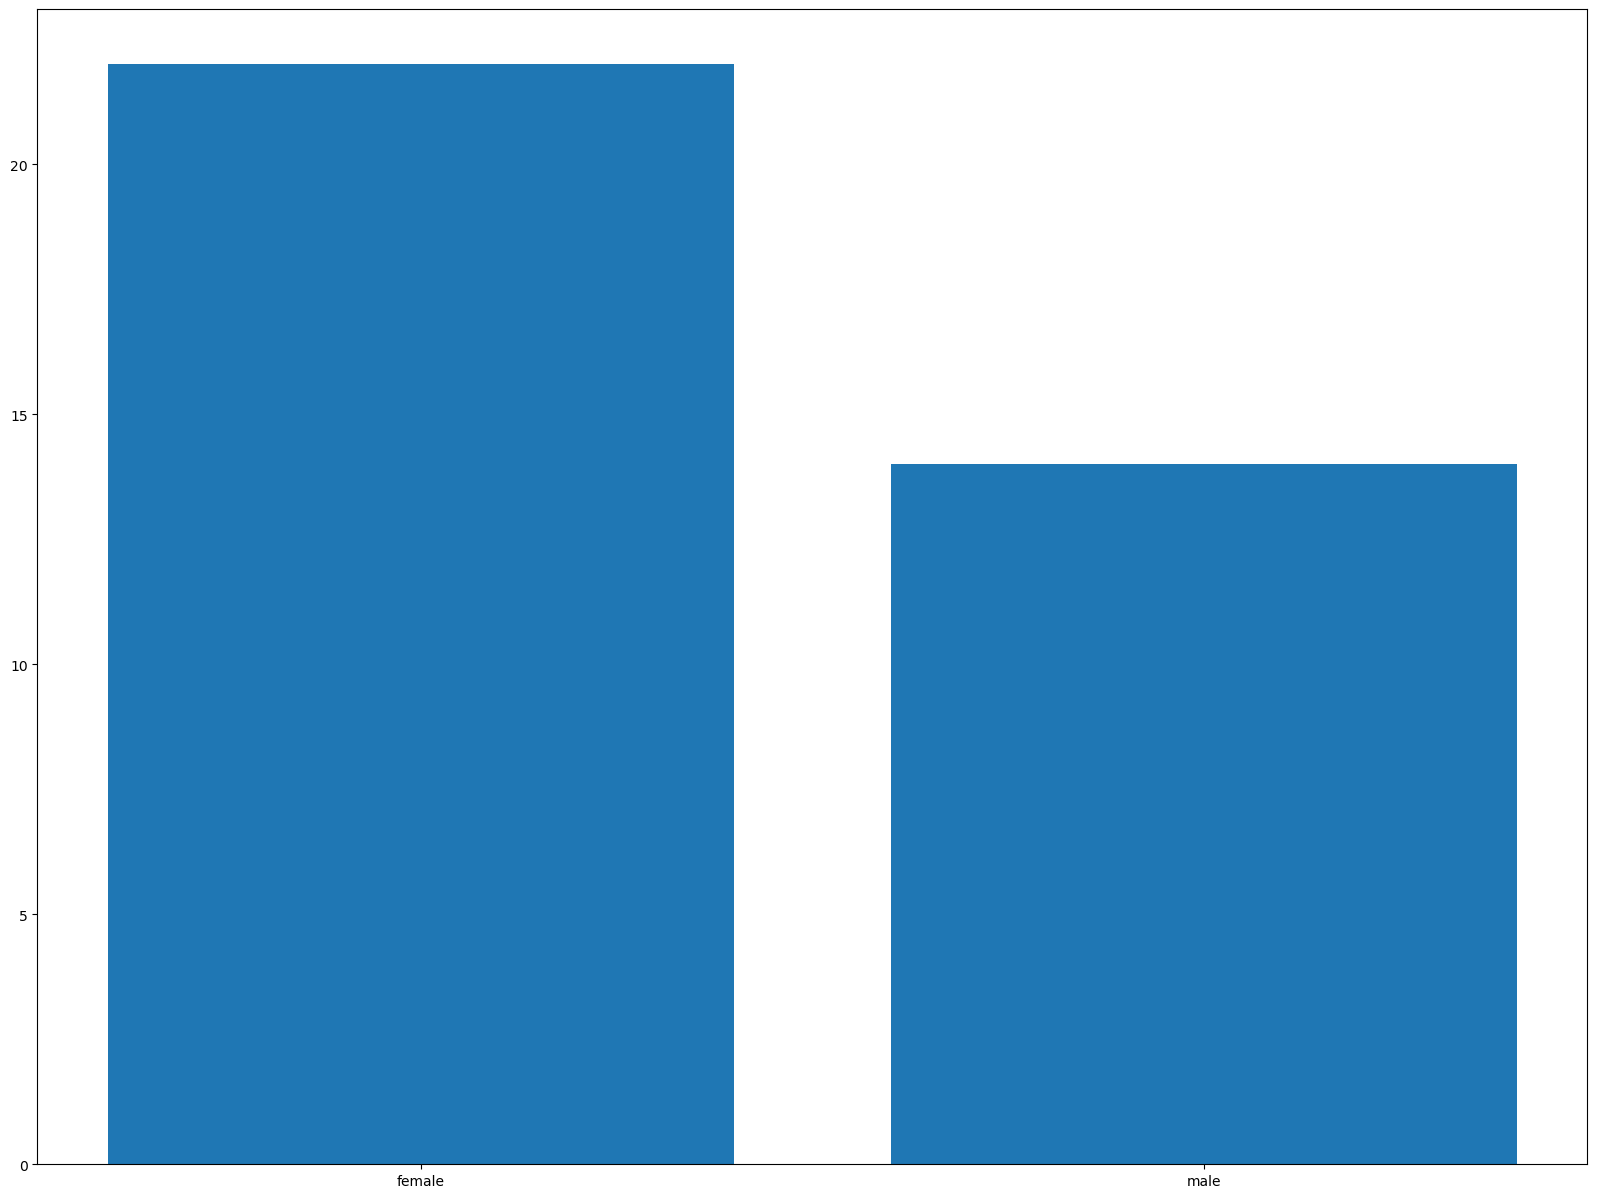

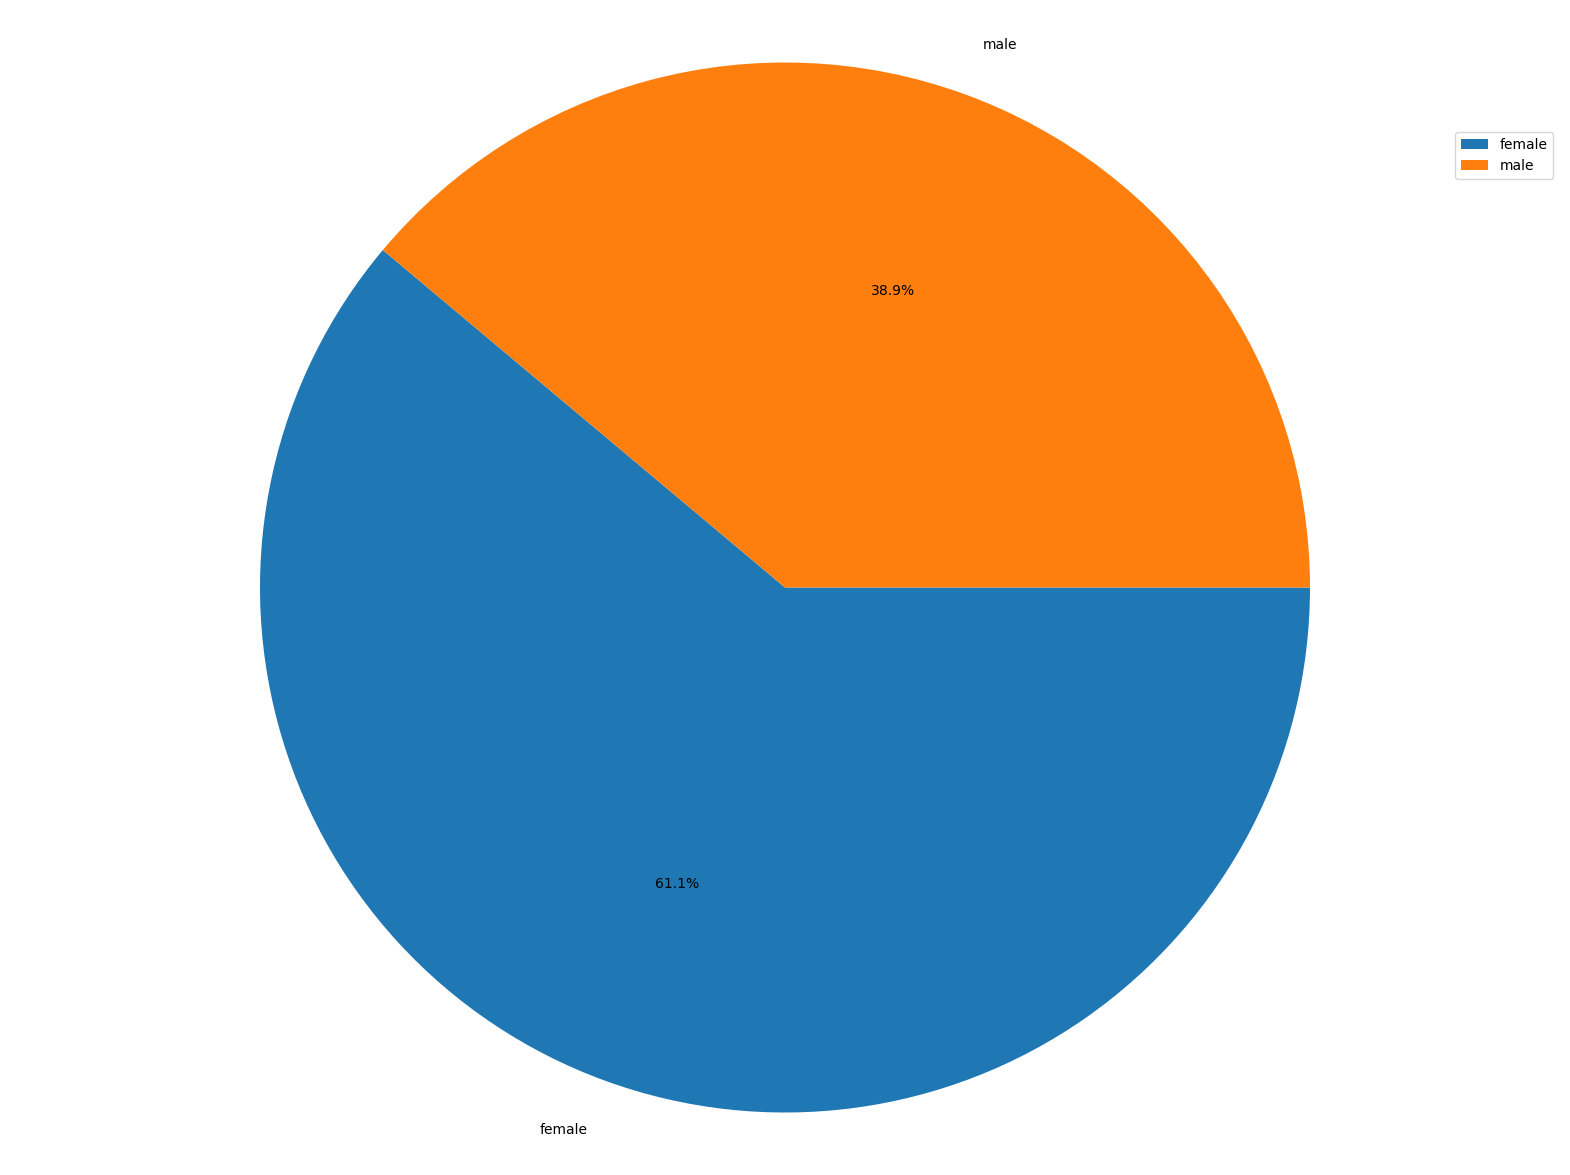

sex,count
str,u32
"""female""",22
"""male""",14


In [34]:
# 1.2 how is the split in sex
grouped_by_sex = df.groupby('sex').count()

barchart(grouped_by_sex['sex'], grouped_by_sex['count'], figsize=figsize)
piechart(grouped_by_sex['sex'], grouped_by_sex['count'], figsize=figsize)

grouped_by_sex.head()

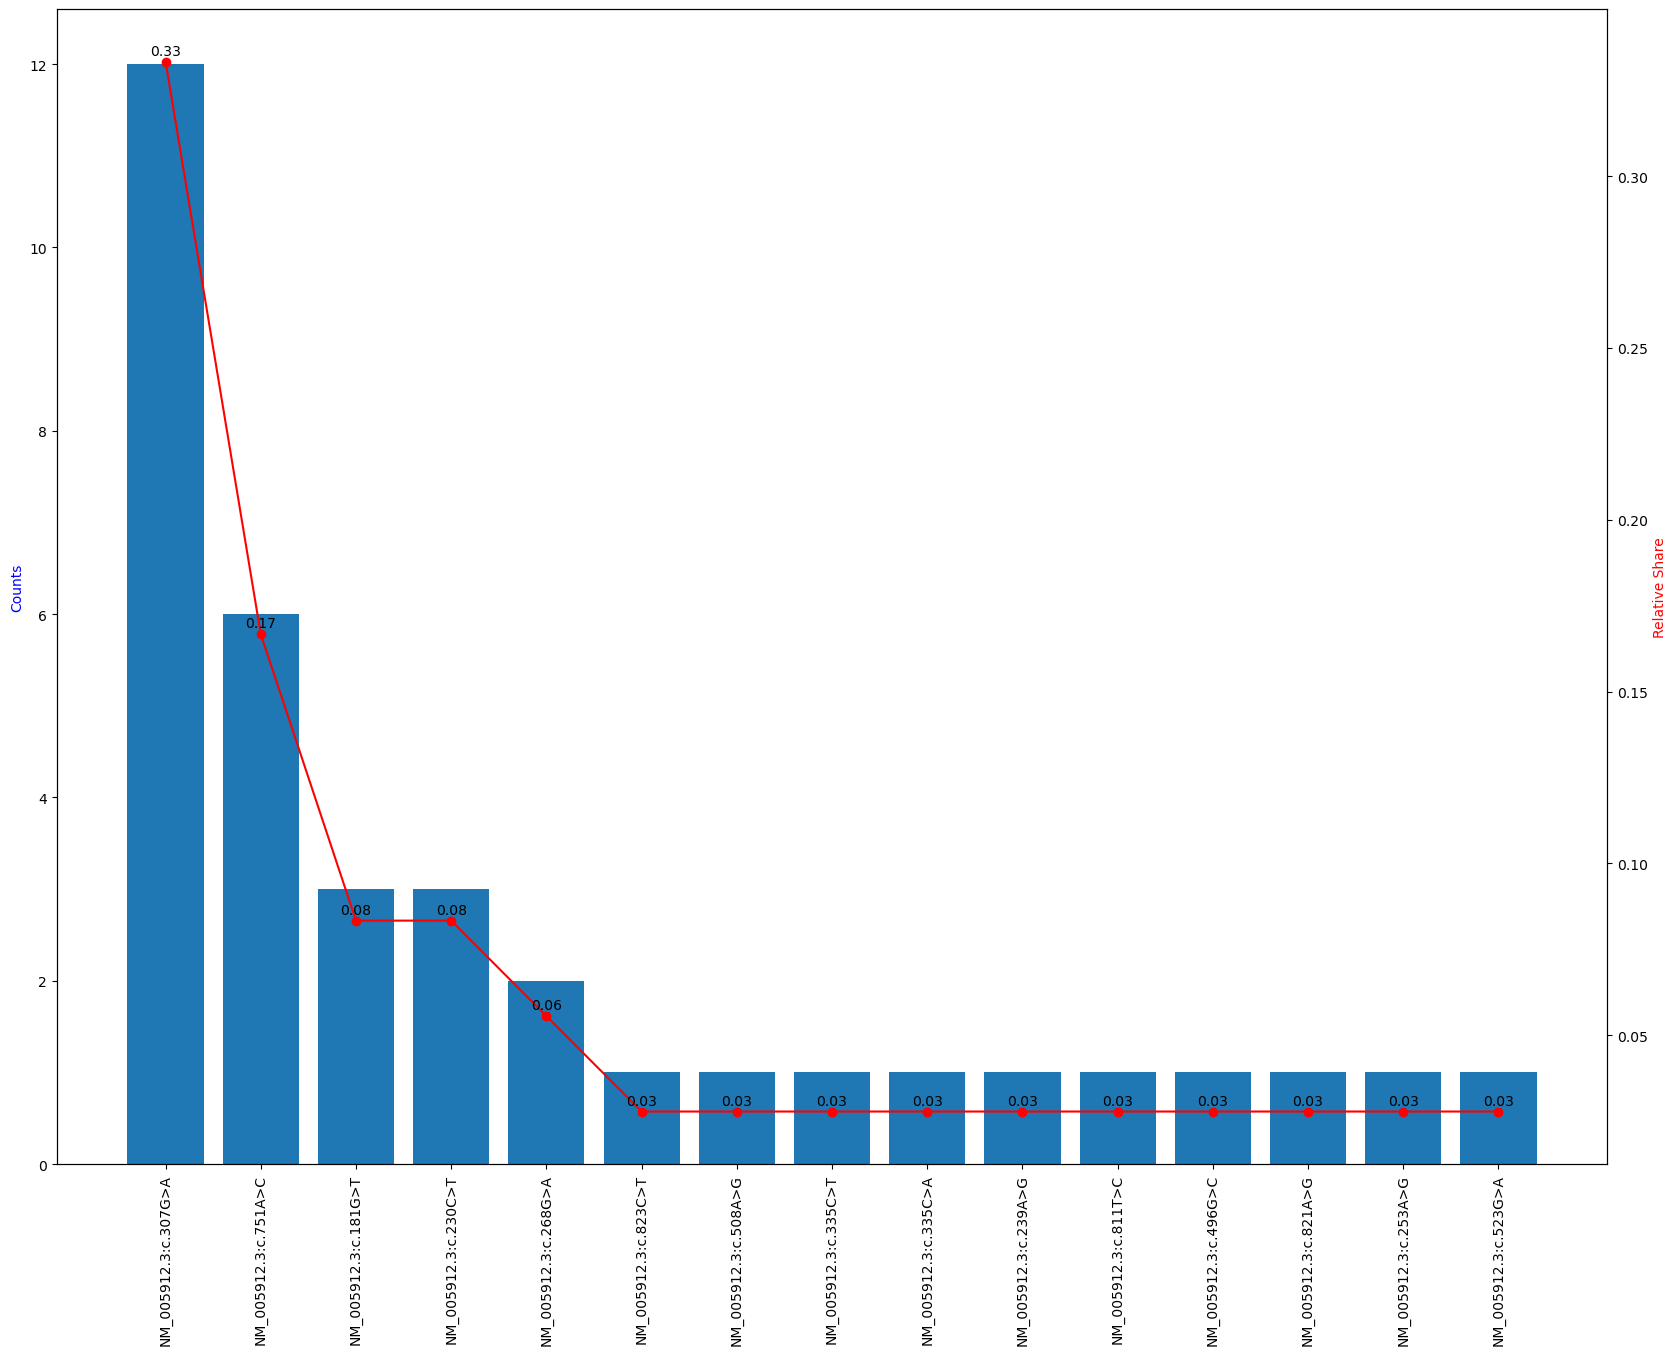

c_hgvs,count
str,u32
"""NM_005912.3:c.…",12
"""NM_005912.3:c.…",6
"""NM_005912.3:c.…",3
"""NM_005912.3:c.…",3
"""NM_005912.3:c.…",2
"""NM_005912.3:c.…",1
"""NM_005912.3:c.…",1
"""NM_005912.3:c.…",1
"""NM_005912.3:c.…",1


In [35]:
# 2. Distribution of c_hgvs mutations?
grouped_by_c_hgvs = df.groupby('c_hgvs').count().sort('count', descending=True)
num_c_hgvs = grouped_by_c_hgvs.height

# barchart(grouped_by_c_hgvs['c_hgvs'], grouped_by_c_hgvs['count'], figsize=figsize, x_tick_rotation='vertical')

barchart_relative_distribution(grouped_by_c_hgvs['c_hgvs'], grouped_by_c_hgvs['count'], figsize=figsize, x_tick_rotation='vertical')

grouped_by_c_hgvs.head(50)

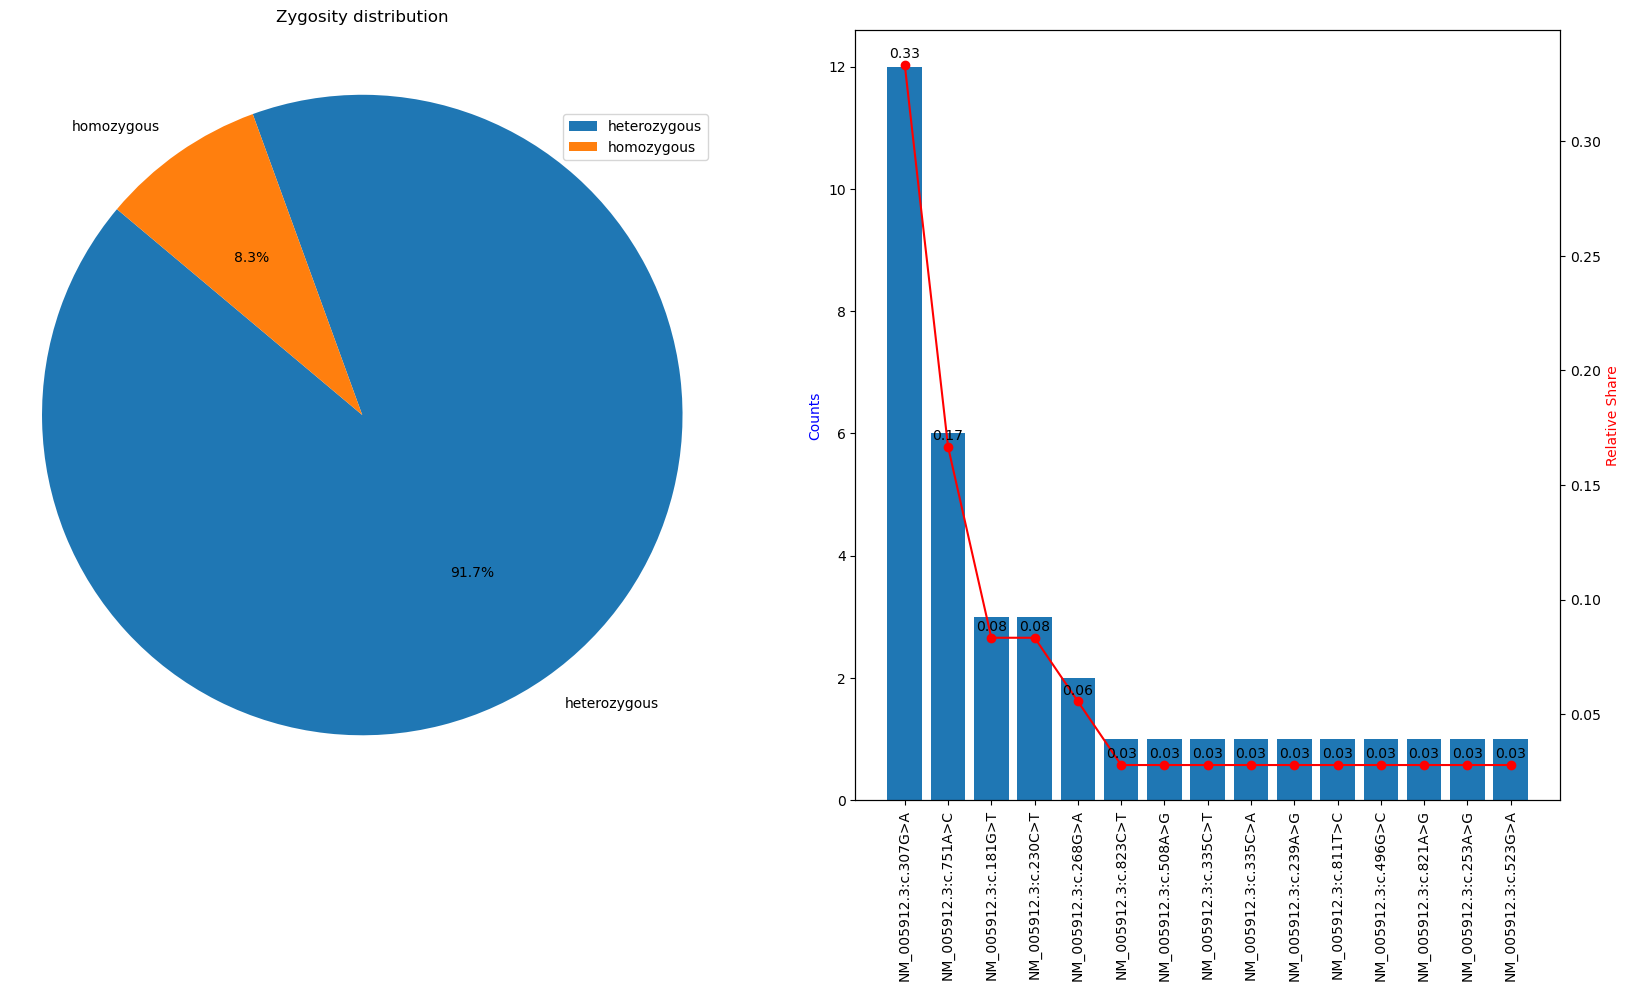

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
piechart_subplot(ax1, grouped_by_zygosity['zygosity'], grouped_by_zygosity['count'], 'Zygosity distribution',)
barchart_relative_distribution_subplot(ax2, grouped_by_c_hgvs['c_hgvs'], grouped_by_c_hgvs['count'], 'c_hgvs distribution', x_tick_rotation='vertical')
plt.show()

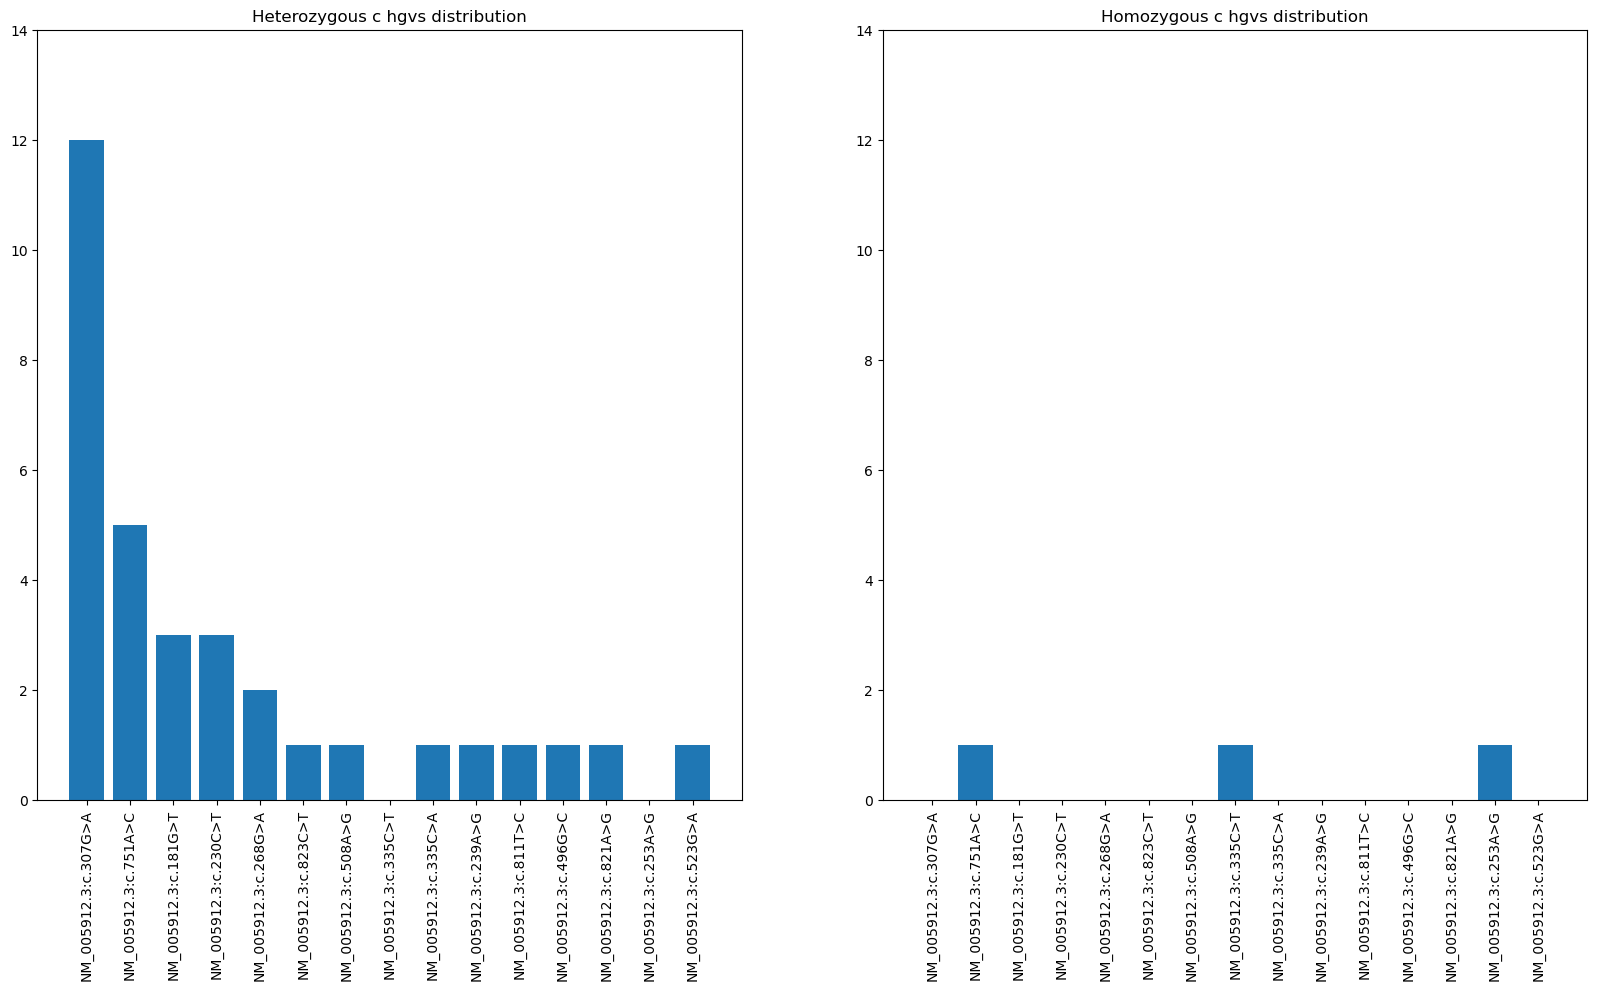

In [37]:
from ERKER2Phenopackets.src.utils.polars_utils import contingency_table

# 3. What if we split the distribution of c_hgvs mutations by zygosity?
# barchart_3d(df, 'zygosity', 'c_hgvs', figsize=figsize, grouped_by_col1=grouped_by_zygosity, grouped_by_col2=grouped_by_c_hgvs) # not really useful

ct_zygosity_c_hgvs = contingency_table(df, 'zygosity', 'c_hgvs', grouped_by_zygosity['zygosity'], grouped_by_c_hgvs['c_hgvs'])
heterozygous_c_hgvs_frquency, homozygous_c_hgvs_frquency = ct_zygosity_c_hgvs[0], ct_zygosity_c_hgvs[1]
y_lim = int(np.max(ct_zygosity_c_hgvs) * 1.1) + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
barchart_subplot(ax1, grouped_by_c_hgvs['c_hgvs'], heterozygous_c_hgvs_frquency, 'Heterozygous c hgvs distribution', x_tick_rotation='vertical', y_min=0, y_max=y_lim)
barchart_subplot(ax2, grouped_by_c_hgvs['c_hgvs'], homozygous_c_hgvs_frquency, 'Homozygous c hgvs distribution', x_tick_rotation='vertical', y_min=0, y_max=y_lim)
plt.show()

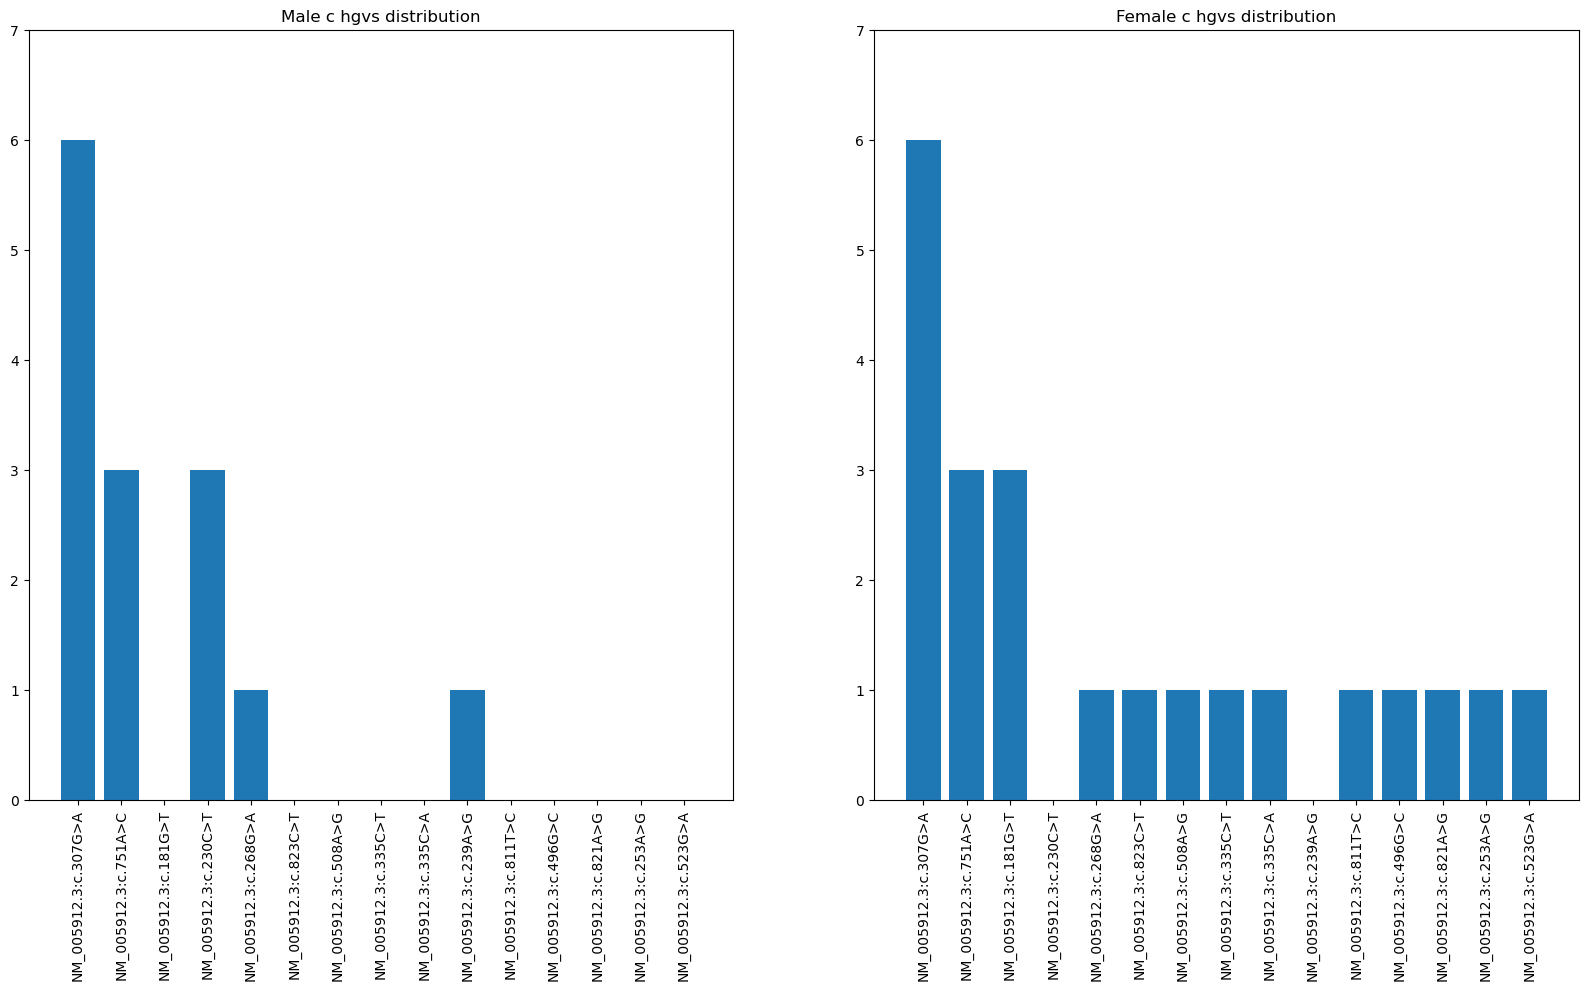

In [38]:
ct_sex_c_hgvs = contingency_table(df, 'sex', 'c_hgvs', ('male', 'female'), grouped_by_c_hgvs['c_hgvs'])
male_c_hgvs_frquency, female_c_hgvs_frquency = ct_sex_c_hgvs[0], ct_sex_c_hgvs[1]
y_lim = int(np.max(ct_sex_c_hgvs) * 1.1) + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
barchart_subplot(ax1, grouped_by_c_hgvs['c_hgvs'], male_c_hgvs_frquency, 'Male c hgvs distribution', x_tick_rotation='vertical', y_min=0, y_max=y_lim)
barchart_subplot(ax2, grouped_by_c_hgvs['c_hgvs'], female_c_hgvs_frquency, 'Female c hgvs distribution', x_tick_rotation='vertical', y_min=0, y_max=y_lim)
plt.show()

In [39]:
from ERKER2Phenopackets.src.utils.polars_utils import melt_groupby_count, sort_columns

# 4. Distribution of obesity classes?
# 4.1 count appearance of obesity classes/ hpo terms at each of the 3 inspections
result = melt_groupby_count(df, columns=['obesity_label0', 'obesity_label1', 'obesity_label2', 'obesity_label3', 'obesity_label4']).sort(by='value')

result = sort_columns(result, ['value'])

print(result.head(50))

shape: (5, 6)
┌────────────────┬────────────────┬────────────────┬───────────────┬───────────────┬───────────────┐
│ value          ┆ obesity_label0 ┆ obesity_label1 ┆ obesity_label ┆ obesity_label ┆ obesity_label │
│ ---            ┆ ---            ┆ ---            ┆ 2             ┆ 3             ┆ 4             │
│ str            ┆ u32            ┆ u32            ┆ ---           ┆ ---           ┆ ---           │
│                ┆                ┆                ┆ u32           ┆ u32           ┆ u32           │
╞════════════════╪════════════════╪════════════════╪═══════════════╪═══════════════╪═══════════════╡
│ Class I        ┆ 0              ┆ 4              ┆ 0             ┆ 1             ┆ 0             │
│ obesity        ┆                ┆                ┆               ┆               ┆               │
│ (HP:0025499)   ┆                ┆                ┆               ┆               ┆               │
│ Class II       ┆ 1              ┆ 1              ┆ 0             ┆ 0       

In [40]:
column_names = tuple(result['value'])
transpose = result.transpose(column_names=column_names)
if column_names != transpose.row(0):
    raise Exception('New column names do not match old row names')
transpose = transpose.tail(5)
print(transpose.head(50))

shape: (5, 5)
┌─────────────────┬──────────────────┬──────────────┬──────────────┬───────────────────────────────┐
│ Class I obesity ┆ Class II obesity ┆ Not recorded ┆ Overweight   ┆ Refuted Obesity (HP:0001513)  │
│ (HP:0025499)    ┆ (HP:0025500)     ┆ ---          ┆ (HP:0025502) ┆ ---                           │
│ ---             ┆ ---              ┆ str          ┆ ---          ┆ str                           │
│ str             ┆ str              ┆              ┆ str          ┆                               │
╞═════════════════╪══════════════════╪══════════════╪══════════════╪═══════════════════════════════╡
│ 0               ┆ 1                ┆ 7            ┆ 0            ┆ 28                            │
│ 4               ┆ 1                ┆ 23           ┆ 2            ┆ 6                             │
│ 0               ┆ 0                ┆ 32           ┆ 1            ┆ 3                             │
│ 1               ┆ 0                ┆ 34           ┆ 0            ┆ 1       

In [41]:
def cast(column):
    return column.cast(pl.Int32).to_list()

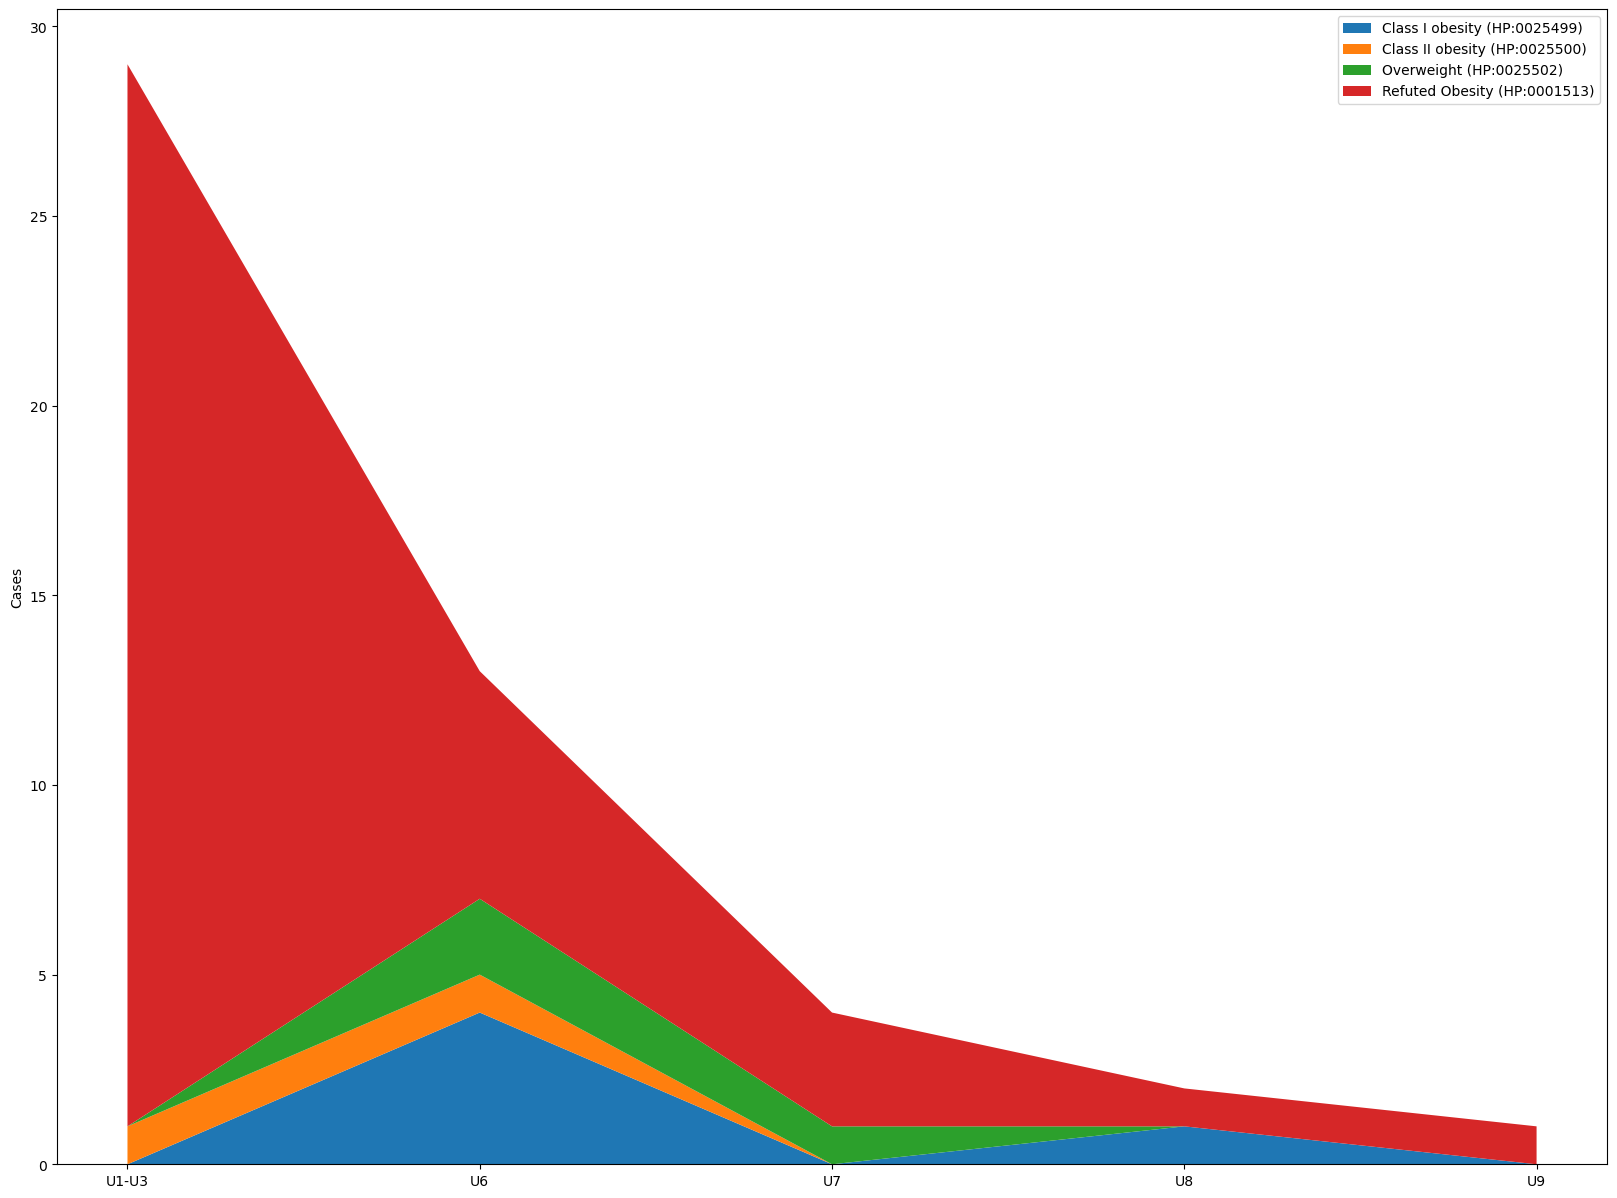

In [42]:
categories = ['Class I obesity (HP:0025499)', 'Class II obesity (HP:0025500)', 'Overweight (HP:0025502)', 'Refuted Obesity (HP:0001513)']
time_stamps = ['U1-U3', 'U6', 'U7', 'U8', 'U9']


values = [cast(transpose[cat]) for cat in categories]

plt.figure(figsize=figsize)

plt.stackplot(range(5), values[0], values[1], values[2], values[3], labels=categories)
plt.xticks(range(5), time_stamps)
plt.ylabel('Cases')
plt.legend()
plt.show()

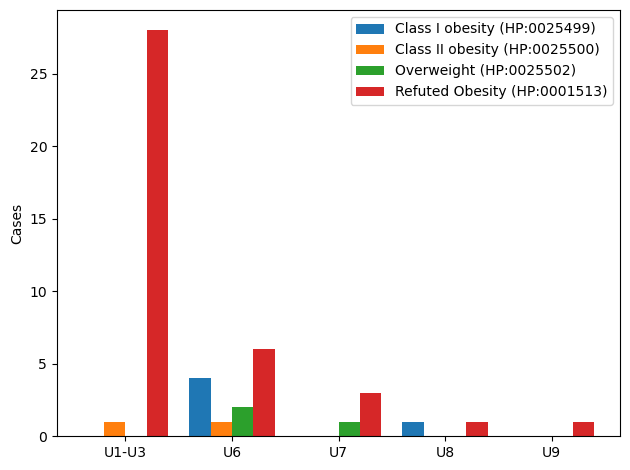

In [43]:
from ERKER2Phenopackets.src.utils.polars_utils import barchart_multiple

barchart_multiple(time_stamps, values, 'Cases', categories)

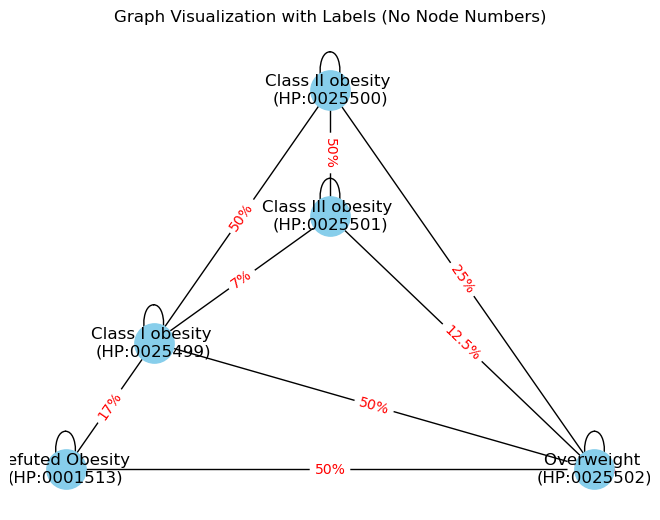

In [44]:
import networkx as nx
import matplotlib.pyplot as plt

def linear_layout(G):
    nodes_list = list(G.nodes())
    pos = {node: (index, 0) for index, node in enumerate(nodes_list)}
    return pos


def create_graph(vertex_labels, edge_labels, adjacency_list):
    G = nx.Graph()

    for i, vl in enumerate(vertex_labels):
        G.add_node(i, label=vl)

    for i, al in enumerate(adjacency_list):
        for k, j in enumerate(al):
            G.add_edge(i, j, label=edge_labels[i][k])
            
    return G

def graphplot(vertex_labels, edge_labels, adjacency_list):
    G = create_graph(vertex_labels, edge_labels, adjacency_list)
    
    pos = nx.planar_layout(G)

    # Create a mapping for node labels without numbers
    node_labels = {node: label['label'] for node, label in G.nodes(data=True)}
    
    # Draw the graph without node labels
    nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=800, font_weight='bold', font_size=12)
    
    # Draw node labels without numbers
    nx.draw_networkx_labels(G, pos, labels=node_labels)
    
    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title('Graph Visualization with Labels (No Node Numbers)')
    plt.show()
    return G
    
vertex_labels = ['Refuted Obesity \n(HP:0001513)', 'Overweight \n(HP:0025502)', 'Class I obesity \n(HP:0025499)', 'Class II obesity \n(HP:0025500)', 'Class III obesity \n(HP:0025501)']
edge_labels = [
    ['33%', '50%', '17%'],
    ['12.5%', '50%', '25%', '12.5%'],
    ['43%', '50%', '7%'],
    ['50%', '50%'],
    ['100%'],
]
adjacency_list = [
    [0, 1, 2,],
    [1, 2, 3, 4],
    [2, 3, 4],
    [3, 4],
    [4],
]
G = graphplot(vertex_labels, edge_labels, adjacency_list)

In [45]:
import pygraphviz as pgv

# Create a pygraphviz graph object
G_pg = pgv.AGraph(strict=False, directed=True)

# Add nodes with attributes
for node, attr in G.nodes(data=True):
    G_pg.add_node(node, label=attr.get("label", str(node)))

# Add edges with attributes
for edge in G.edges(data=True):
    src, dest, attr = edge
    G_pg.add_edge(src, dest, label=attr.get("label", ""))

# Set layout engine
G_pg.layout(prog="dot")

# Save or display the Graphviz graph
file_path = "networkx_to_pygraphviz.png"
G_pg.draw(file_path, format="png")

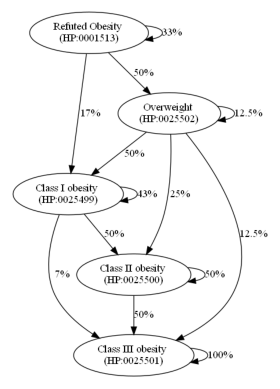

In [52]:
import matplotlib.pyplot as plt




imageplot(file_path)

In [46]:
# 5. What if we split the distribution of obesity classes by zygosity?

In [47]:
# 6. What if we split the distribution of obesity classes by c_hgvs mutation?

In [48]:
# 7. What if we split the distribution of obesity classes by c_hgvs mutation and zygosity?

In [49]:
# 8. How long does it take for a person to develop the different obesity classes based on their mutation?
# Welche Mutationen führt dazu vor dem 5ten lj obesity class 3 zu entwickeln und mit welcher Wahrscheinlichkeit?

In [50]:
# 9. Most severe mutation?